# Experiment Log Analysis

This notebook parses the log files from different experiments, extracts relevant data, and visualizes the results using various plots.

In [9]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

## Function to Parse a Single Log File

This function reads the content of a log file, extracts the number of epochs, training loss, validation loss, and validation accuracy for both normal and QAT models. It also extracts the test accuracy and model size.

In [10]:
def parse_log_file(file_path):
    with open(file_path, 'r') as file:
        content = file.read()

    # Extract normal model accuracy and size
    normal_model_match = re.search(r'Accuracy of the normal model on the test dataset: ([0-9.]+)%\nSize \(KB\): ([0-9.]+)\n\nTraining QAT PyTorch Model:', content)
    if not normal_model_match:
        return None
    normal_test_accuracy = float(normal_model_match.group(1))
    normal_size = float(normal_model_match.group(2))

    # Extract epochs data starting from QAT training section
    qat_section = content.split('Training QAT PyTorch Model:')[1]
    epochs = len(re.findall(r'Epoch \[\d+/\d+\]', qat_section))

    # Extract loss and accuracy for QAT model
    qat_train_loss = re.findall(r'Epoch \[\d+/\d+\], Loss: ([0-9.]+)', qat_section)
    qat_val_loss_acc = re.findall(r'Validation Loss: ([0-9.]+), Validation Accuracy: ([0-9.]+)', qat_section)
    qat_model_data = {
        'train_loss': qat_train_loss,
        'val_loss': [v[0] for v in qat_val_loss_acc],
        'val_accuracy': [v[1] for v in qat_val_loss_acc]
    }

    # Extract QAT test accuracy and model size
    test_accuracy_qat = re.findall(r'Accuracy of the QAT model on the test dataset: ([0-9.]+)%', qat_section)
    qat_size = re.findall(r'Size \(KB\): ([0-9.]+)', qat_section)
    autogluon_accuracy = re.findall(r'Accuracy on the test set \(Original AutoGluon Model\): ([0-9.]+)', content)

    return {
        'epochs': epochs,
        'normal_test_accuracy': normal_test_accuracy,
        'normal_size': normal_size,
        'qat_model': qat_model_data,
        'test_accuracy_qat': float(test_accuracy_qat[0]) if test_accuracy_qat else None,
        'qat_size': float(qat_size[0]) if qat_size else None,
        'autogluon_accuracy': float(autogluon_accuracy[0]) if autogluon_accuracy else None
    }

## Function to Parse All Log Files in a Directory

This function iterates over all the log files in the specified directory and uses the `parse_log_file` function to extract the data from each log file.

In [11]:
import os

def parse_all_logs(directory):
    experiment_data = []
    filenames = []

    # List all files in the directory and filter by '.txt' extension
    txt_files = [f for f in os.listdir(directory) if f.endswith('.txt')]

    # Sort the filenames alphabetically
    txt_files.sort()

    # Iterate over the sorted list of filenames
    for filename in txt_files:
        file_path = os.path.join(directory, filename)
        data = parse_log_file(file_path)
        if data:
            experiment_data.append(data)
            filenames.append(filename)

    return experiment_data, filenames

## Function to Plot Data

This function generates various plots to visualize the extracted data, including the accuracy and size of the models over the epochs, and the training and validation loss of the QAT model over the epochs.

In [12]:
import numpy as np
# Function to plot data
def plot_data(experiment_data, filenames):
    for i, exp in enumerate(experiment_data):
        experiment_number = re.findall(r'\d+', filenames[i])[0]
        
        labels = ['AutoGluon', 'Normal Model', 'QAT Model']
        accuracies = [
            (exp['autogluon_accuracy'] * 100) if exp['autogluon_accuracy'] is not None else 0,
            exp['normal_test_accuracy'] if exp['normal_test_accuracy'] is not None else 0,
            exp['test_accuracy_qat'] if exp['test_accuracy_qat'] is not None else 0
        ]

        plt.figure(figsize=(10, 6))
        bars = plt.bar(labels, accuracies, color=['green', 'red', 'blue'])
        plt.ylabel('Accuracy (%)')
        plt.title(f'Final Accuracies for Experiment {experiment_number}')
        plt.ylim(0, 100)

        # Adding value labels inside the bars
        for bar, acc in zip(bars, accuracies):
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2.0, yval - 5, round(acc, 2), ha='center', va='top', color='white')  # ha: horizontal alignment, va: vertical alignment

        plt.show()

        # Print the accuracy values
        print(f'Experiment {experiment_number} Final Accuracies:')
        for label, acc in zip(labels, accuracies):
            print(f'{label}: {acc:.2f}%')
        print(f'Epochs: {exp["epochs"]}\n')

        epochs = exp['epochs']

        # Convert the accuracy lists to numpy arrays with float data type
        qat_val_accuracy = np.array(exp['qat_model']['val_accuracy'], dtype=float)
        
        plt.figure(figsize=(12, 6))
        plt.scatter(range(1, epochs + 1), qat_val_accuracy, color='blue', label='QAT Model Val Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Validation Accuracy')
        plt.legend()
        plt.title(f'Validation Accuracy Over Epochs for QAT Model (Experiment {experiment_number})')
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.show()

        # Optional: Apply data smoothing for better visualization
        if len(qat_val_accuracy) >= 10:  # Ensure we have enough data points for smoothing
            qat_val_acc_smoothed = np.convolve(qat_val_accuracy, np.ones(10)/10, mode='valid')
            
            plt.figure(figsize=(12, 6))
            plt.plot(range(1, len(qat_val_acc_smoothed) + 1), qat_val_acc_smoothed, 'bo-', label='QAT Model Val Accuracy (Smoothed)')
            plt.xlabel('Epochs')
            plt.ylabel('Validation Accuracy')
            plt.legend()
            plt.title(f'Smoothed Validation Accuracy Over Epochs for QAT Model (Experiment {experiment_number})')
            plt.grid(True, which='both', linestyle='--', linewidth=0.5)
            plt.show()

        qat_train_loss = np.array(exp['qat_model']['train_loss'], dtype=float)
        qat_val_loss = np.array(exp['qat_model']['val_loss'], dtype=float)
        
        plt.figure(figsize=(12, 6))
        plt.scatter(range(1, epochs + 1), qat_train_loss, color='blue', label='QAT Model Train Loss')
        plt.scatter(range(1, epochs + 1), qat_val_loss, color='yellow', label='QAT Model Val Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.title(f'Loss Over Epochs for QAT Model (Experiment {experiment_number})')
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.show()

        # Smoothed Train and Validation Loss
        if len(qat_train_loss) >= 10:
            qat_train_loss_smoothed = np.convolve(qat_train_loss, np.ones(10)/10, mode='valid')
            qat_val_loss_smoothed = np.convolve(qat_val_loss, np.ones(10)/10, mode='valid')

            plt.figure(figsize=(12, 6))
            plt.plot(range(1, len(qat_train_loss_smoothed) + 1), qat_train_loss_smoothed, 'bo-', label='QAT Model Train Loss (Smoothed)')
            plt.plot(range(1, len(qat_val_loss_smoothed) + 1), qat_val_loss_smoothed, 'yo-', label='QAT Model Val Loss (Smoothed)')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend()
            plt.title(f'Smoothed Loss Over Epochs for QAT Model (Experiment {experiment_number})')
            plt.grid(True, which='both', linestyle='--', linewidth=0.5)
            plt.show()

        if 'train_loss' in exp and exp['normal_model']['train_loss']:
            normal_train_loss = np.array(exp['normal_model']['train_loss'], dtype=float)
            normal_val_loss = np.array(exp['normal_model']['val_loss'], dtype=float)
            normal_val_accuracy = np.array(exp['normal_model']['val_accuracy'], dtype=float)

            plt.figure(figsize=(12, 6))
            plt.scatter(range(1, epochs + 1), normal_train_loss, color='red', label='Normal Model Train Loss')
            plt.scatter(range(1, epochs + 1), normal_val_loss, color='green', label='Normal Model Val Loss')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend()
            plt.title(f'Loss Over Epochs for Normal Model (Experiment {experiment_number})')
            plt.grid(True, which='both', linestyle='--', linewidth=0.5)
            plt.show()

            # Smoothed Train and Validation Loss for Normal Model
            if len(normal_train_loss) >= 10:
                normal_train_loss_smoothed = np.convolve(normal_train_loss, np.ones(10)/10, mode='valid')
                normal_val_loss_smoothed = np.convolve(normal_val_loss, np.ones(10)/10, mode='valid')

                plt.figure(figsize=(12, 6))
                plt.plot(range(1, len(normal_train_loss_smoothed) + 1), normal_train_loss_smoothed, 'ro-', label='Normal Model Train Loss (Smoothed)')
                plt.plot(range(1, len(normal_val_loss_smoothed) + 1), normal_val_loss_smoothed, 'go-', label='Normal Model Val Loss (Smoothed)')
                plt.xlabel('Epochs')
                plt.ylabel('Loss')
                plt.legend()
                plt.title(f'Smoothed Loss Over Epochs for Normal Model (Experiment {experiment_number})')
                plt.grid(True, which='both', linestyle='--', linewidth=0.5)
                plt.show()

            plt.figure(figsize=(12, 6))
            plt.scatter(range(1, epochs + 1), normal_val_accuracy, color='red', label='Normal Model Val Accuracy')
            plt.xlabel('Epochs')
            plt.ylabel('Validation Accuracy')
            plt.legend()
            plt.title(f'Validation Accuracy Over Epochs for Normal Model (Experiment {experiment_number})')
            plt.grid(True, which='both', linestyle='--', linewidth=0.5)
            plt.show()

    # Bar plot comparing model sizes
    for i, exp in enumerate(experiment_data):
        experiment_number = re.findall(r'\d+', filenames[i])[0]
        
        labels = ['Normal Model', 'QAT Model']
        sizes = [
            exp['normal_size'] if exp['normal_size'] is not None else 0,
            exp['qat_size'] if exp['qat_size'] is not None else 0
        ]
        size_reduction = (sizes[0] - sizes[1]) / sizes[0] * 100 if sizes[0] != 0 else 0

        plt.figure(figsize=(10, 6))
        bars = plt.bar(labels, sizes, color=['red', 'blue'])
        plt.ylabel('Model Size (KB)')
        plt.title(f'Model Sizes for Experiment {experiment_number}')

        # Adding value labels inside the bars
        for bar, size in zip(bars, sizes):
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2.0, yval - 5, f'{size:.2f} KB', ha='center', va='top', color='white')  # ha: horizontal alignment, va: vertical alignment

        plt.text(1, sizes[1] / 2, f'{size_reduction:.2f}% size reduction', ha='center', va='center', color='black', fontsize=12, fontweight='bold')
        plt.show()

        # Print the model sizes
        print(f'Experiment {experiment_number} Model Sizes:')
        for label, size in zip(labels, sizes):
            print(f'{label}: {size:.2f} KB')
        print(f'Size reduction: {size_reduction:.2f}%')
        print()

## Main Script

Specify the directory containing the log files and execute the parsing and plotting functions.

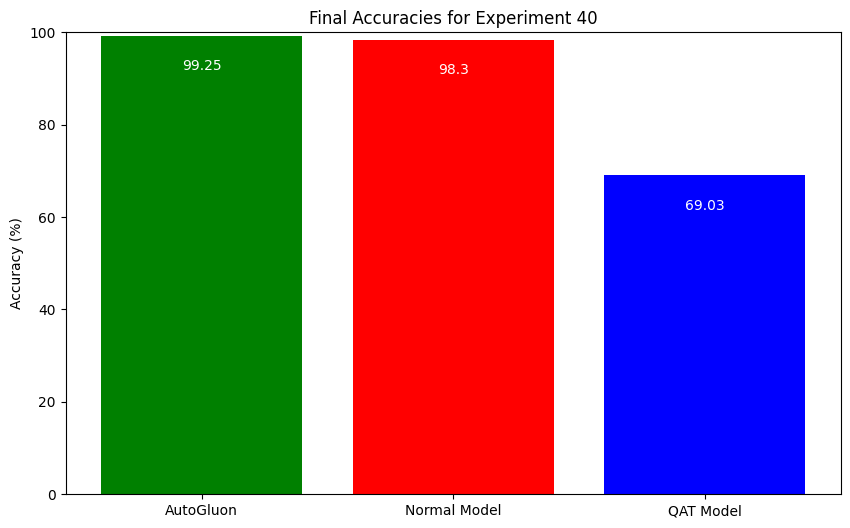

Experiment 40 Final Accuracies:
AutoGluon: 99.25%
Normal Model: 98.30%
QAT Model: 69.03%
Epochs: 100



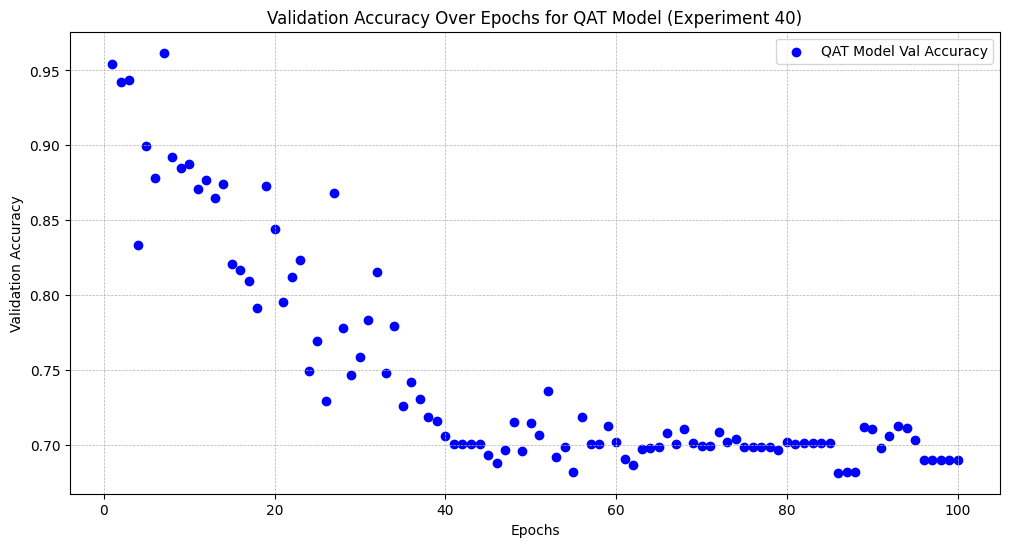

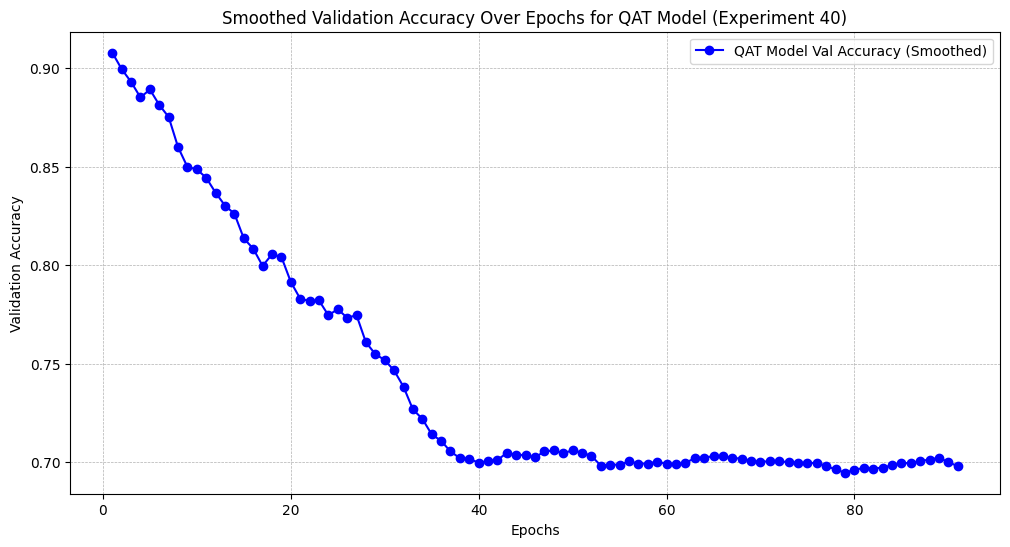

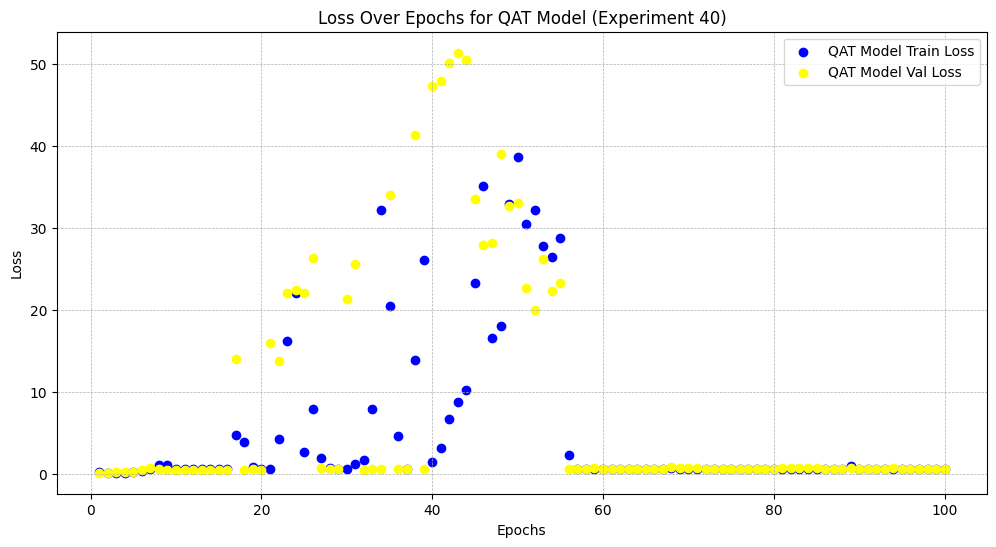

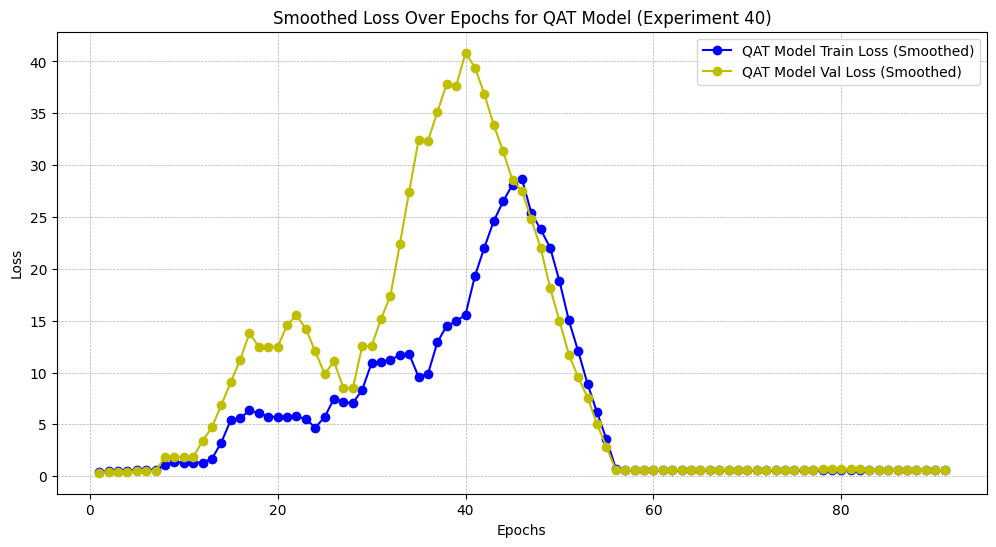

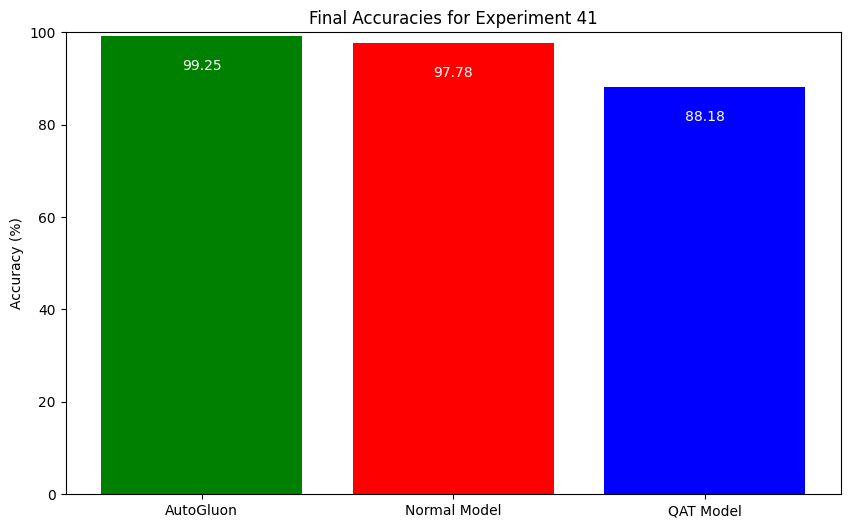

Experiment 41 Final Accuracies:
AutoGluon: 99.25%
Normal Model: 97.78%
QAT Model: 88.18%
Epochs: 18



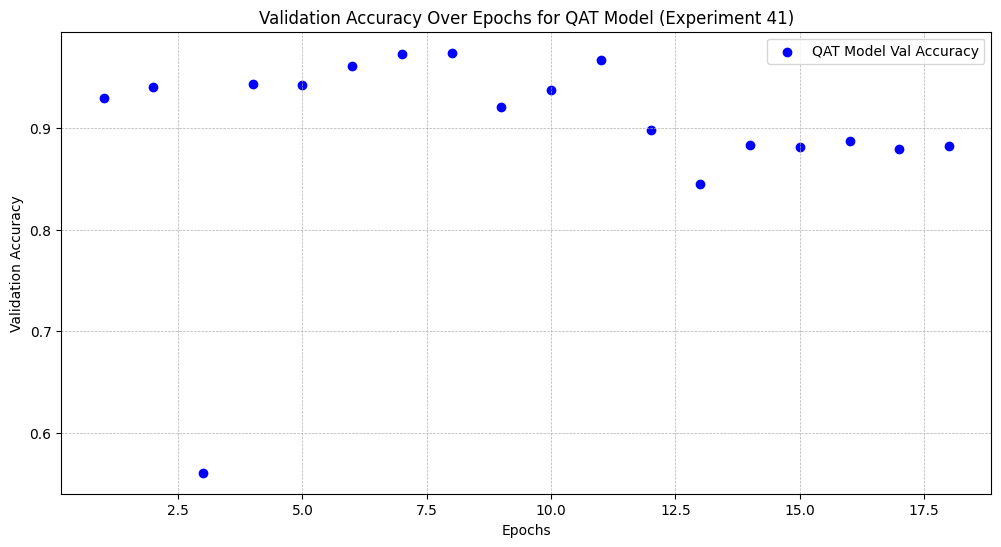

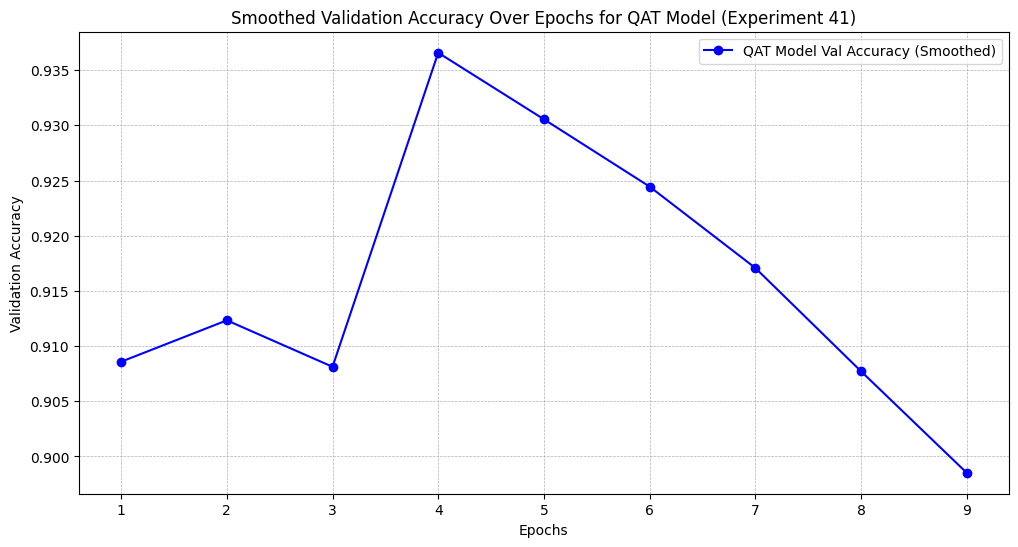

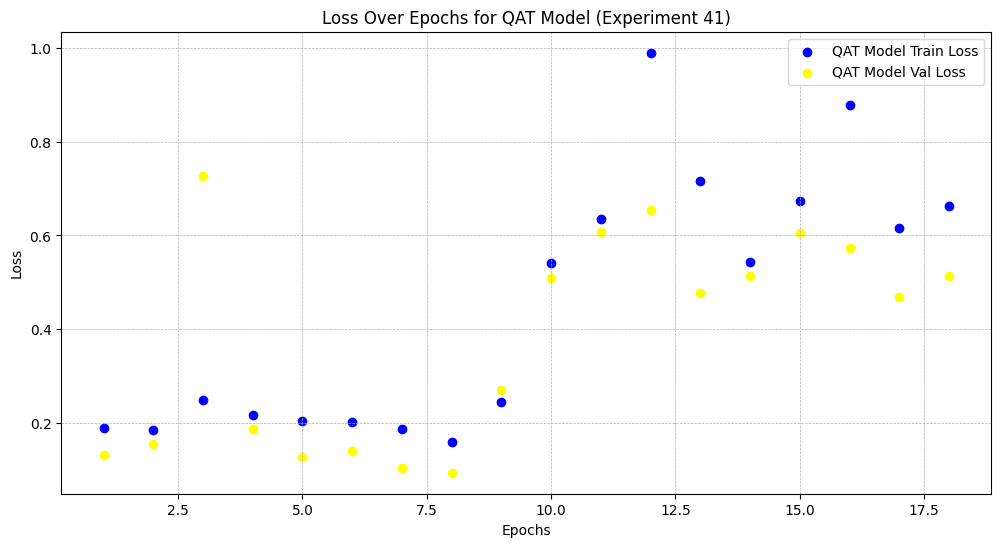

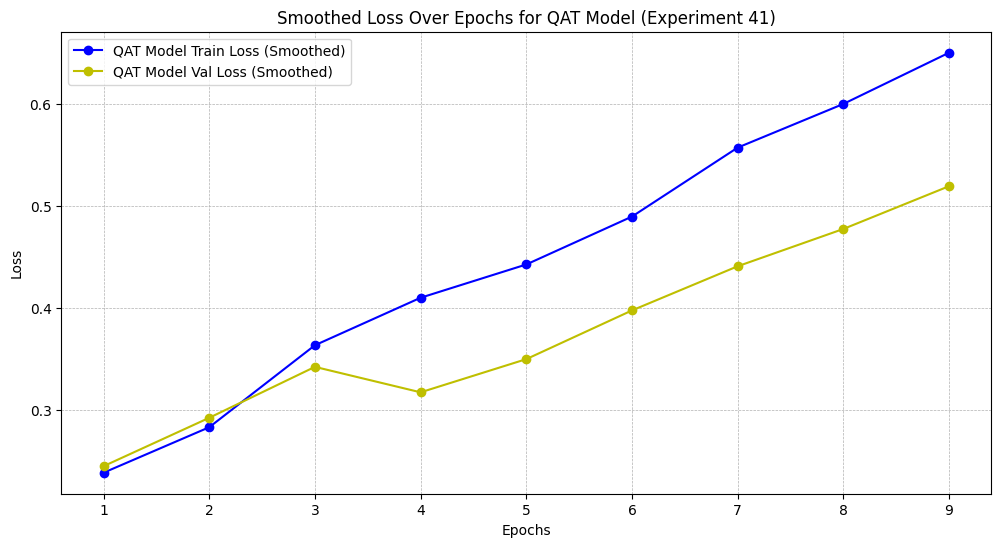

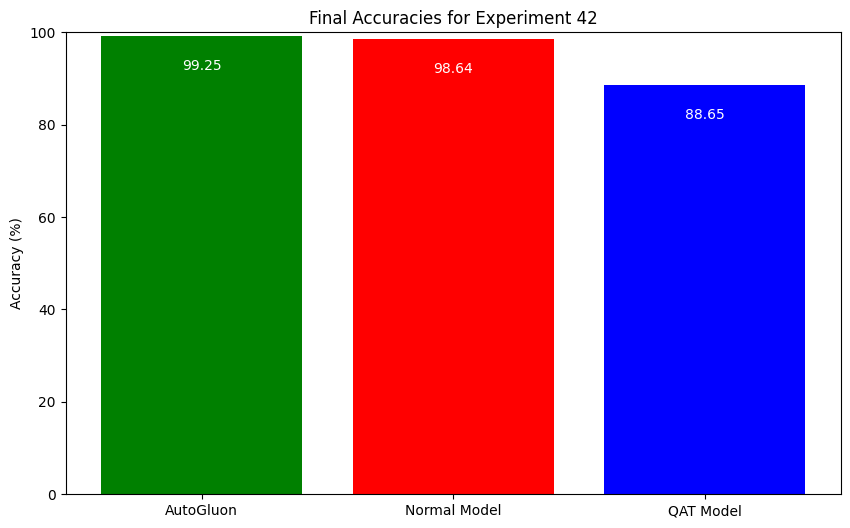

Experiment 42 Final Accuracies:
AutoGluon: 99.25%
Normal Model: 98.64%
QAT Model: 88.65%
Epochs: 100



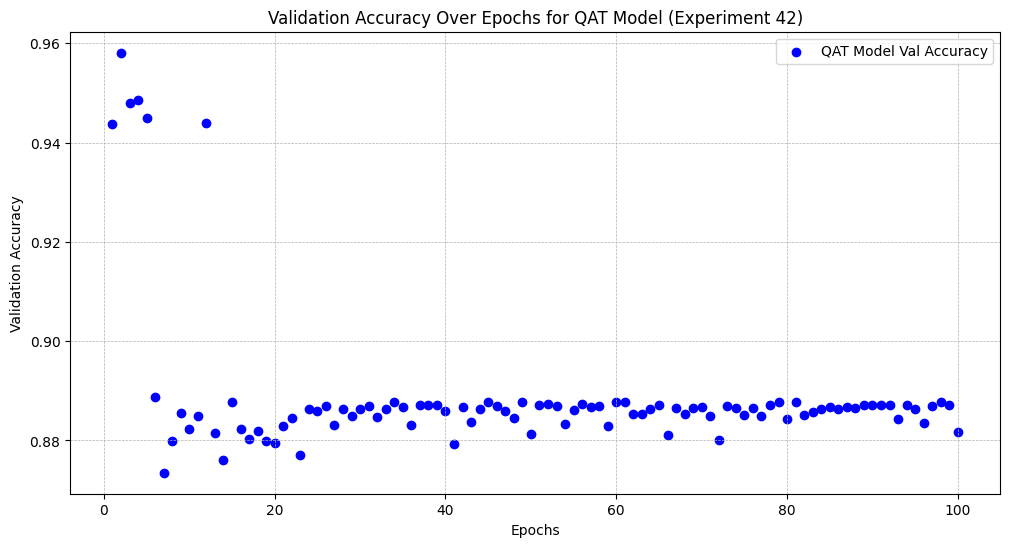

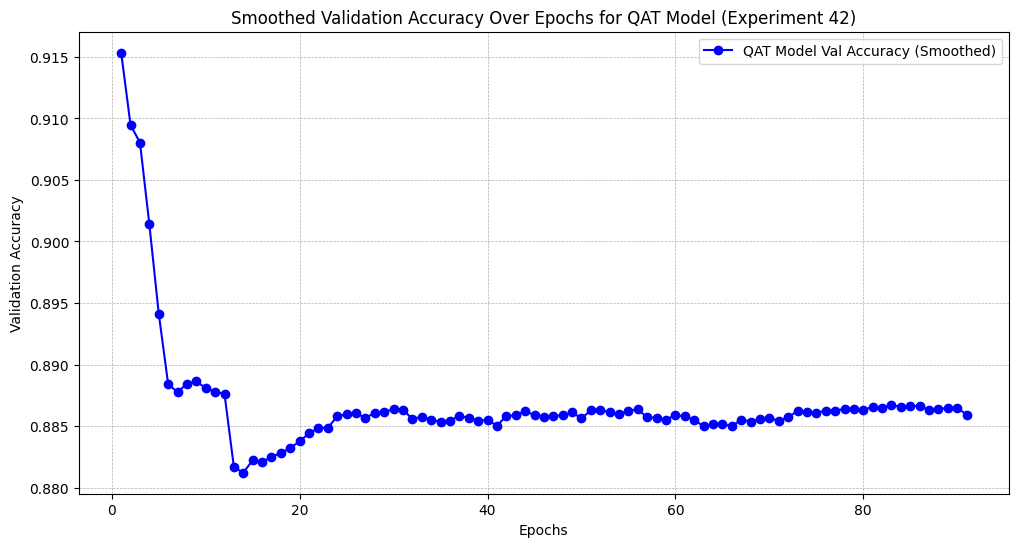

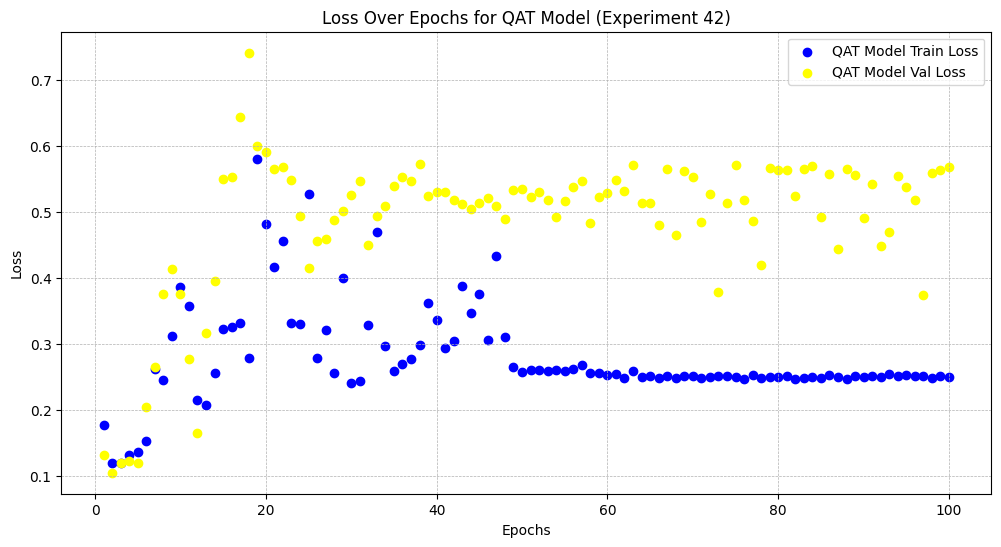

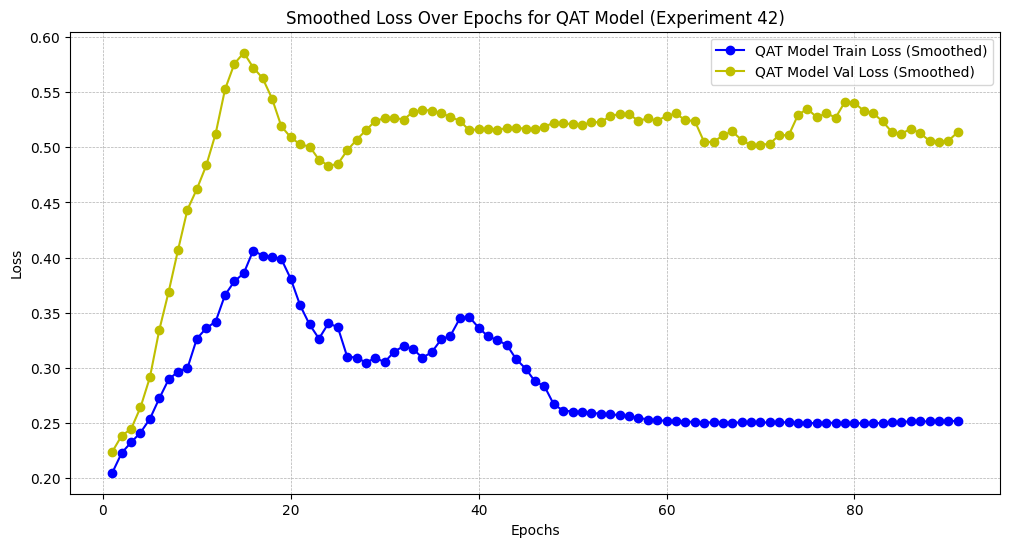

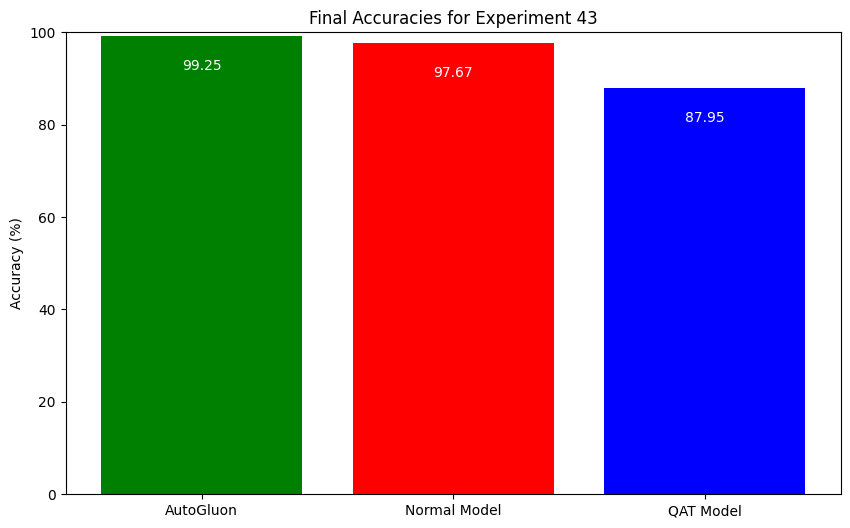

Experiment 43 Final Accuracies:
AutoGluon: 99.25%
Normal Model: 97.67%
QAT Model: 87.95%
Epochs: 12



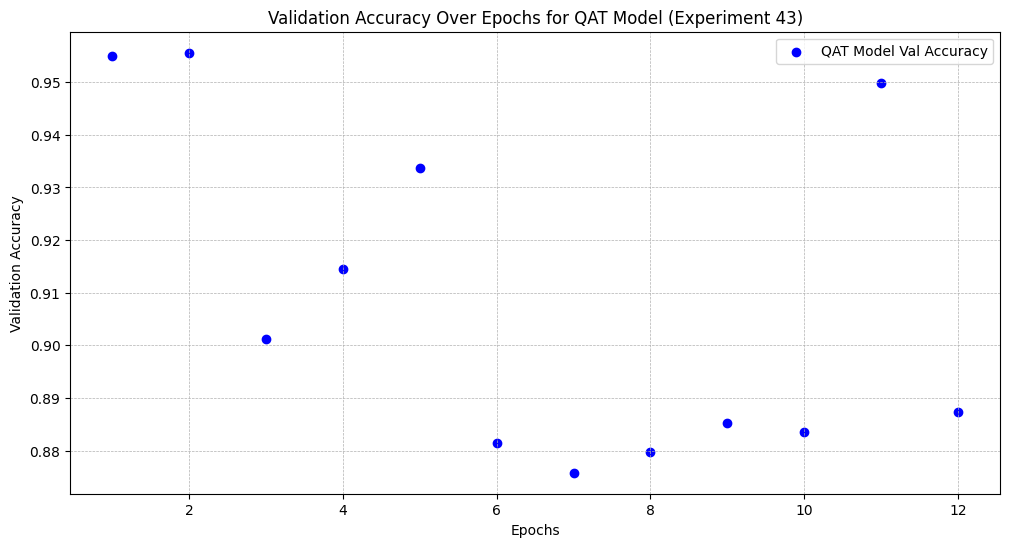

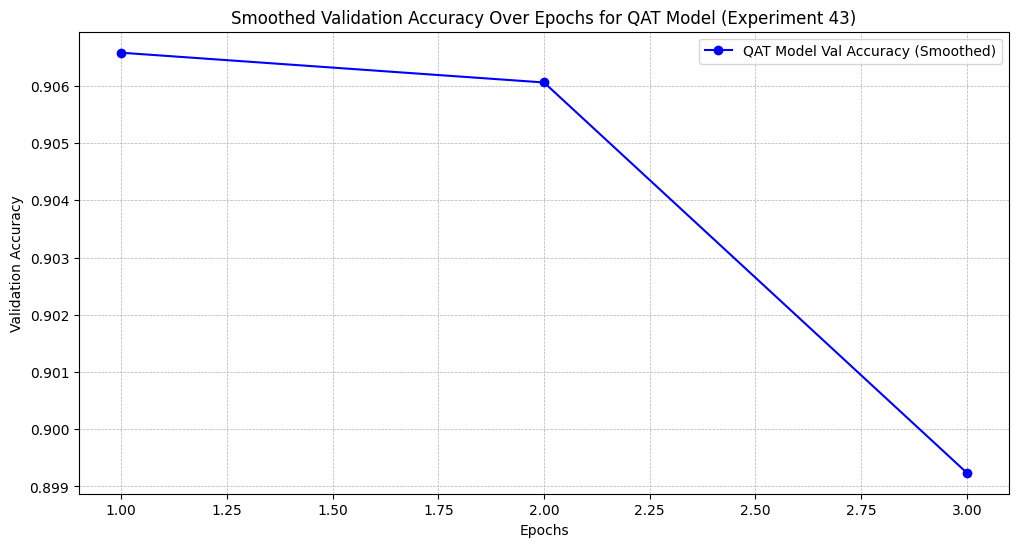

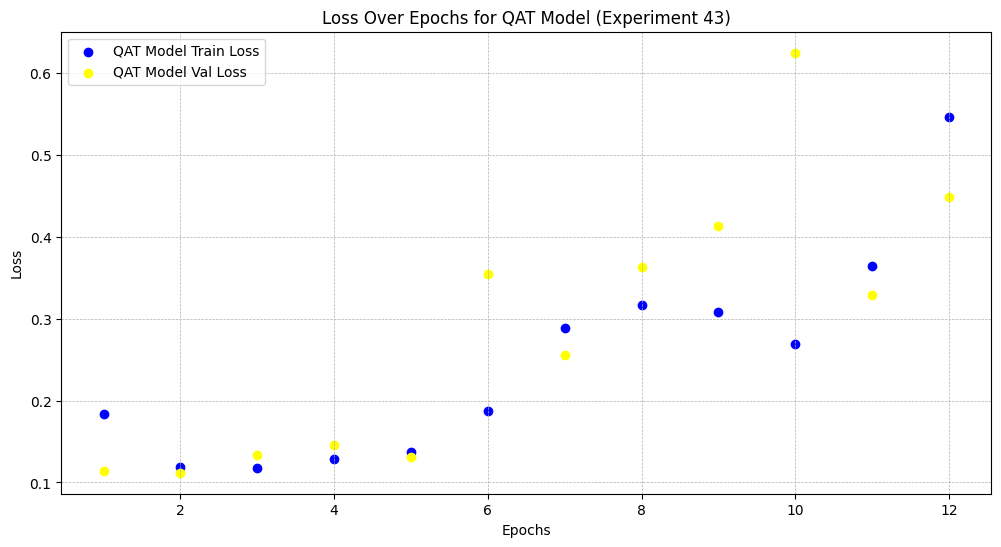

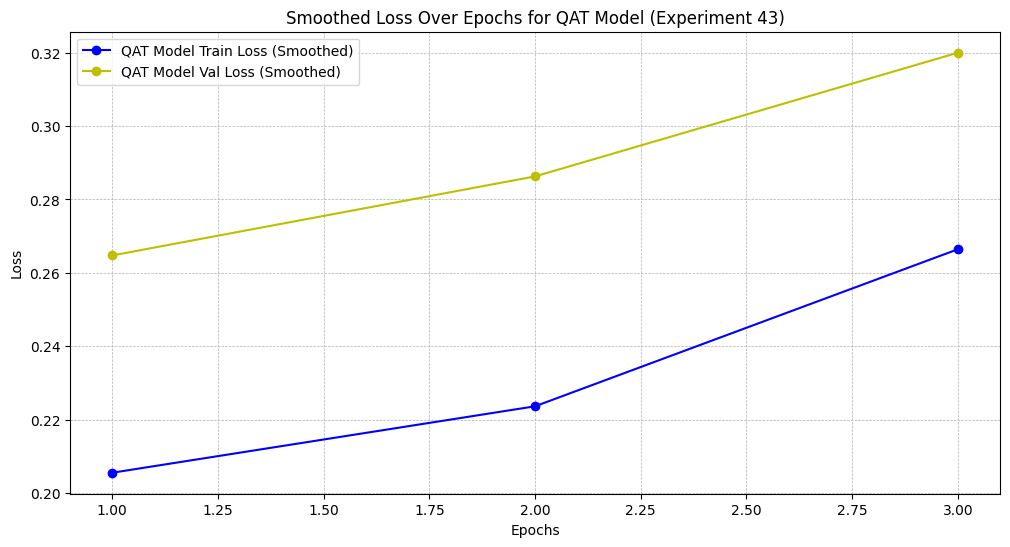

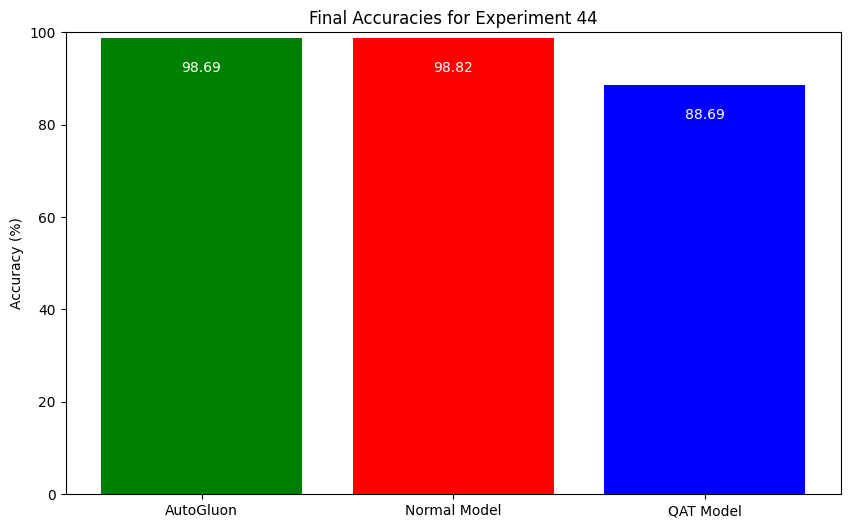

Experiment 44 Final Accuracies:
AutoGluon: 98.69%
Normal Model: 98.82%
QAT Model: 88.69%
Epochs: 100



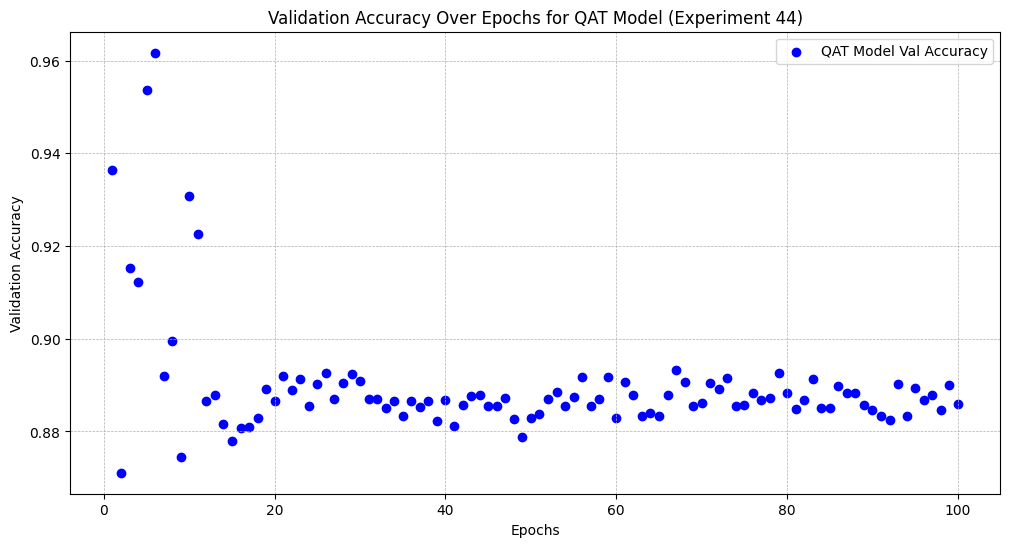

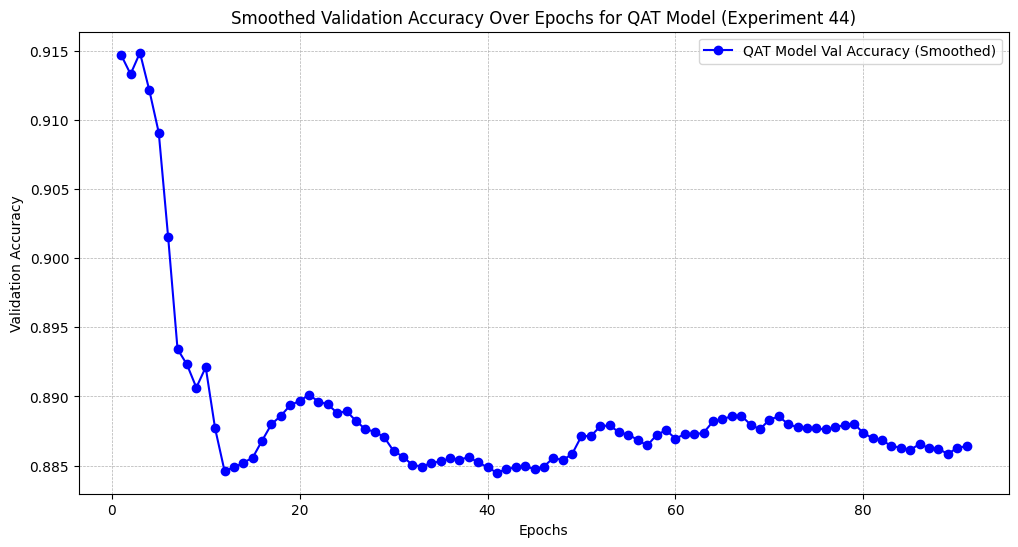

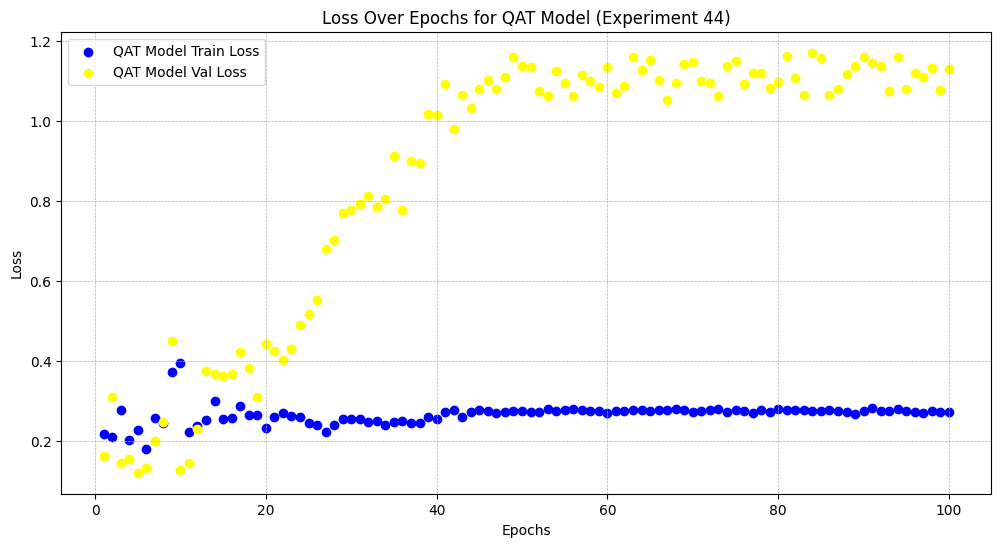

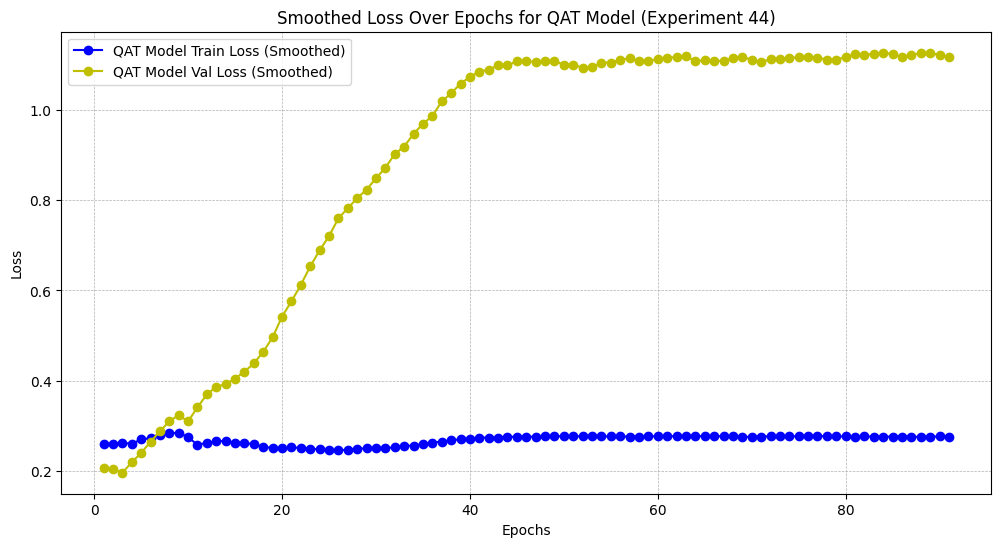

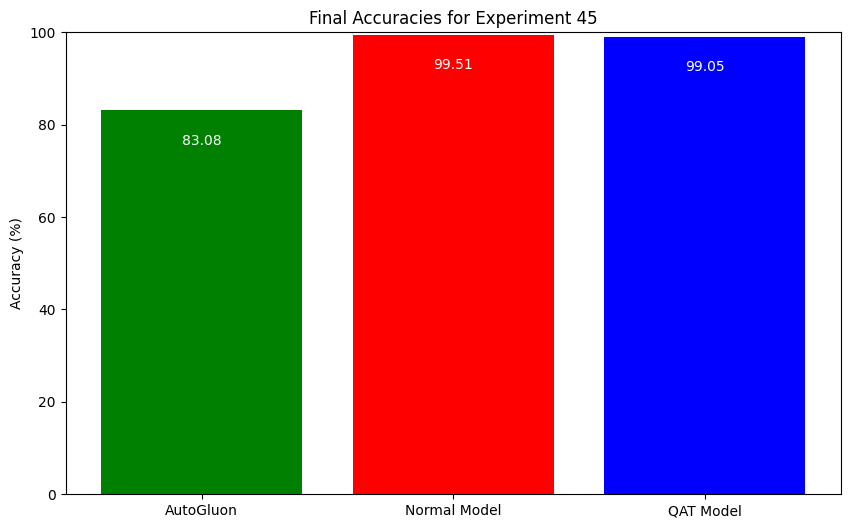

Experiment 45 Final Accuracies:
AutoGluon: 83.08%
Normal Model: 99.51%
QAT Model: 99.05%
Epochs: 100



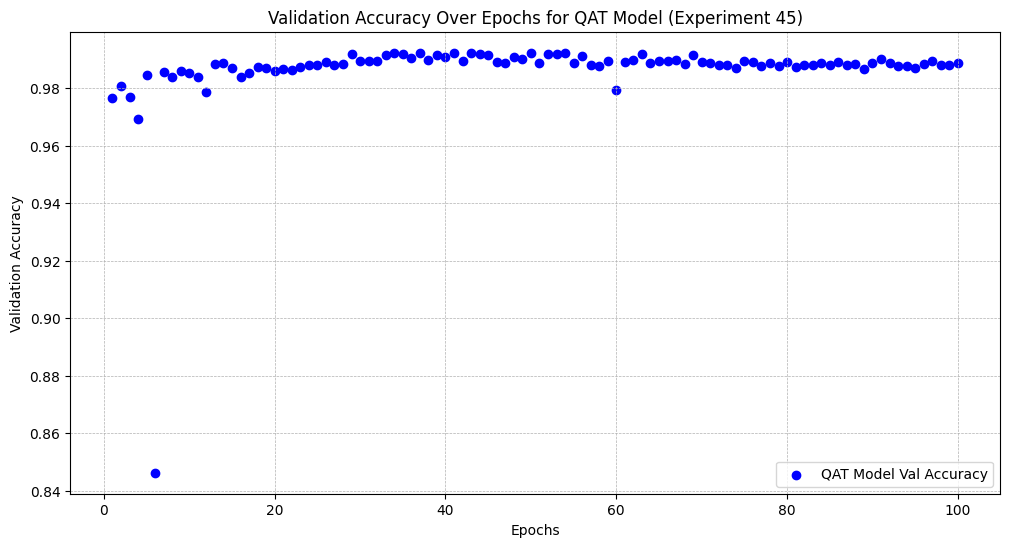

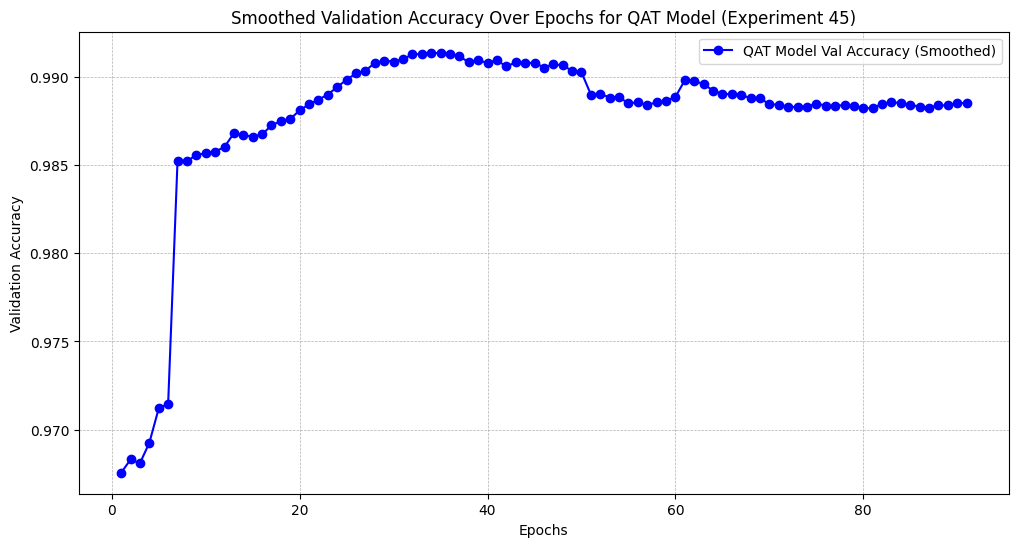

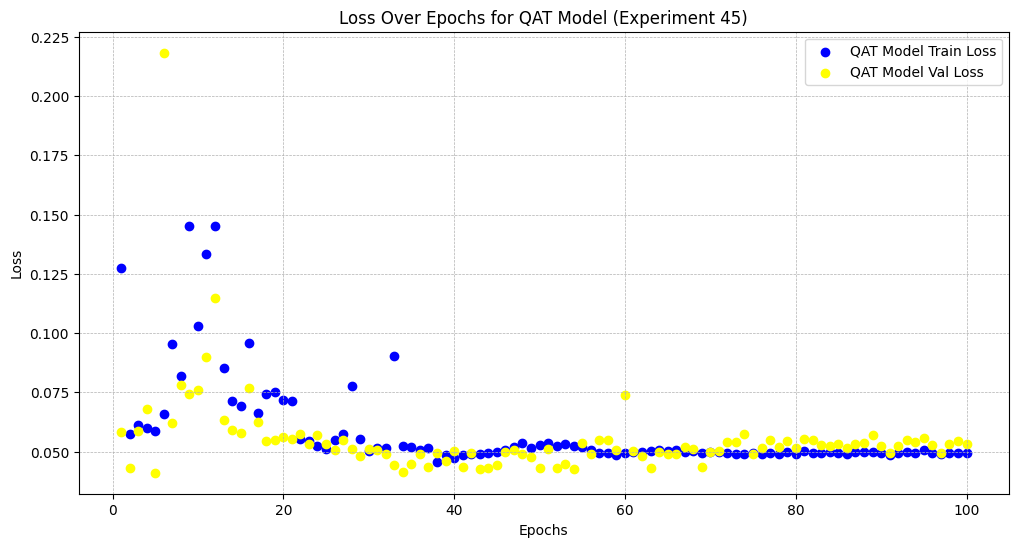

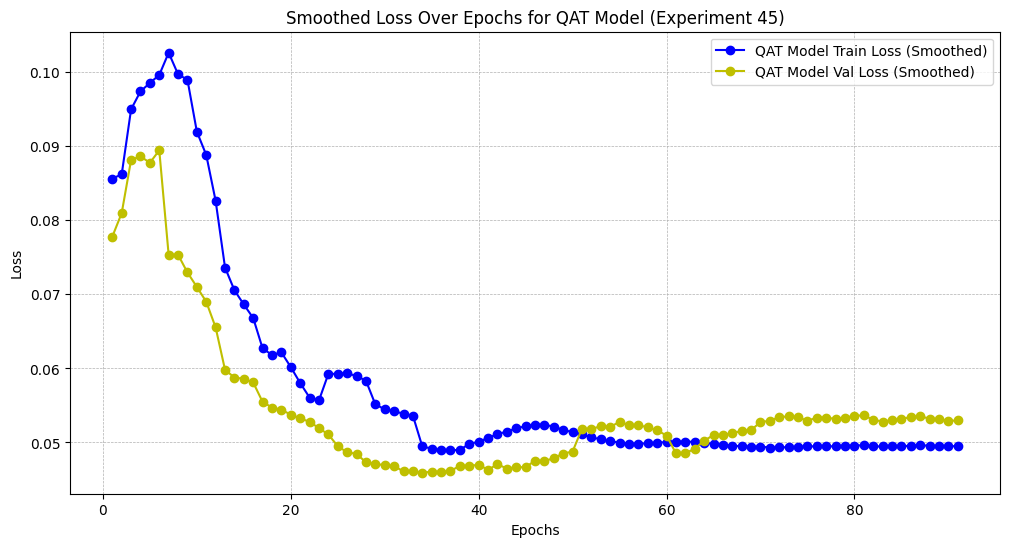

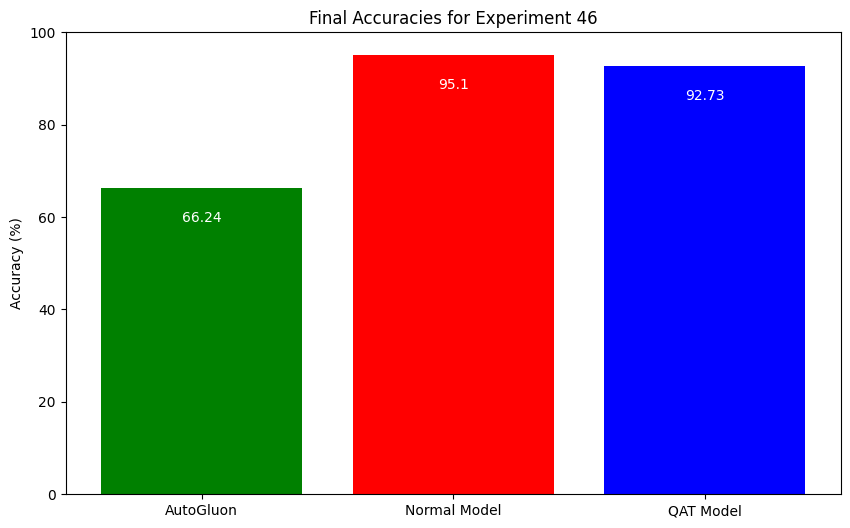

Experiment 46 Final Accuracies:
AutoGluon: 66.24%
Normal Model: 95.10%
QAT Model: 92.73%
Epochs: 100



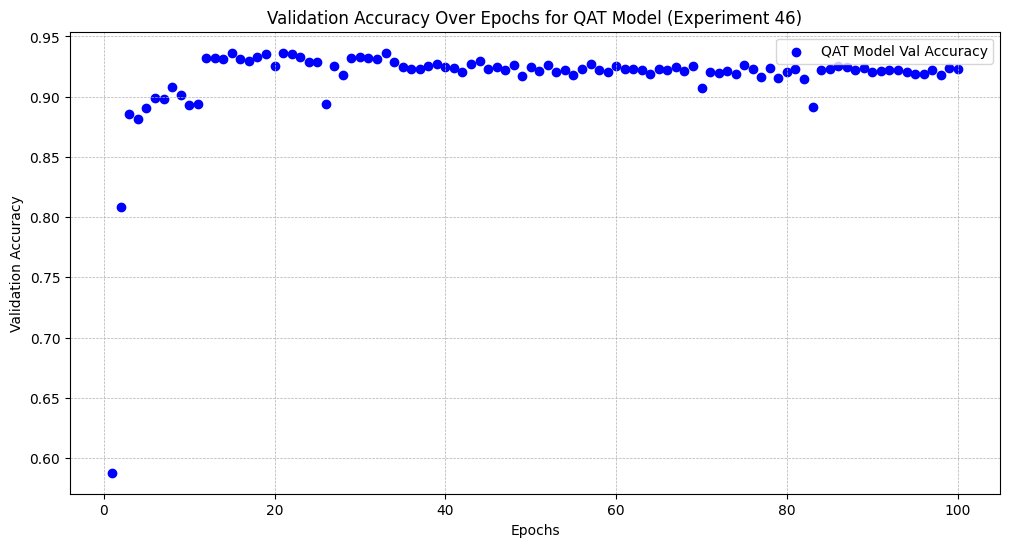

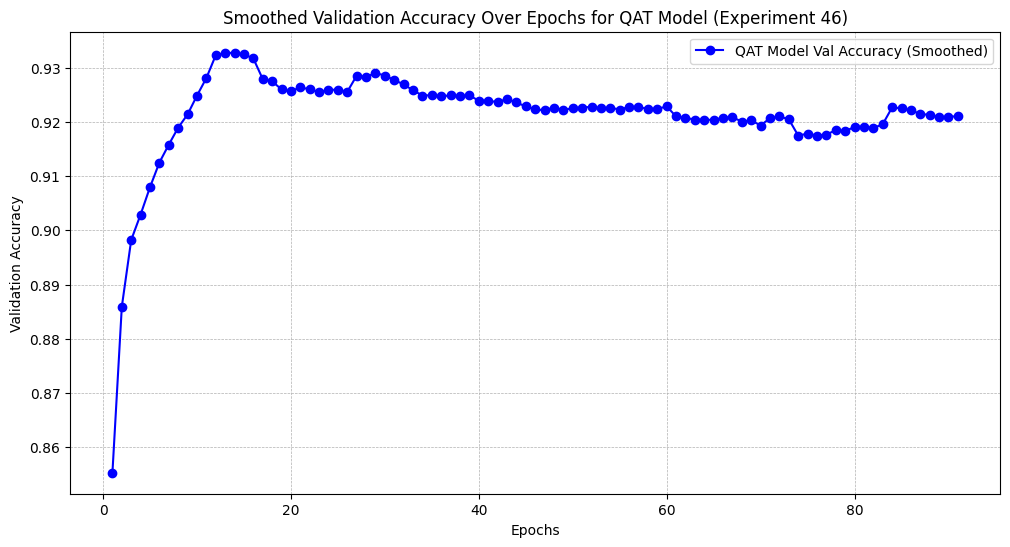

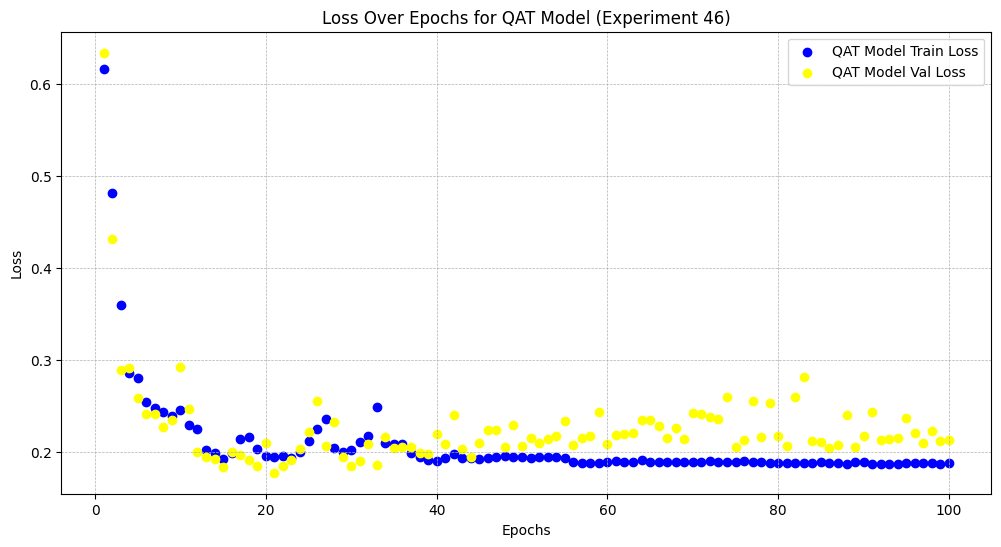

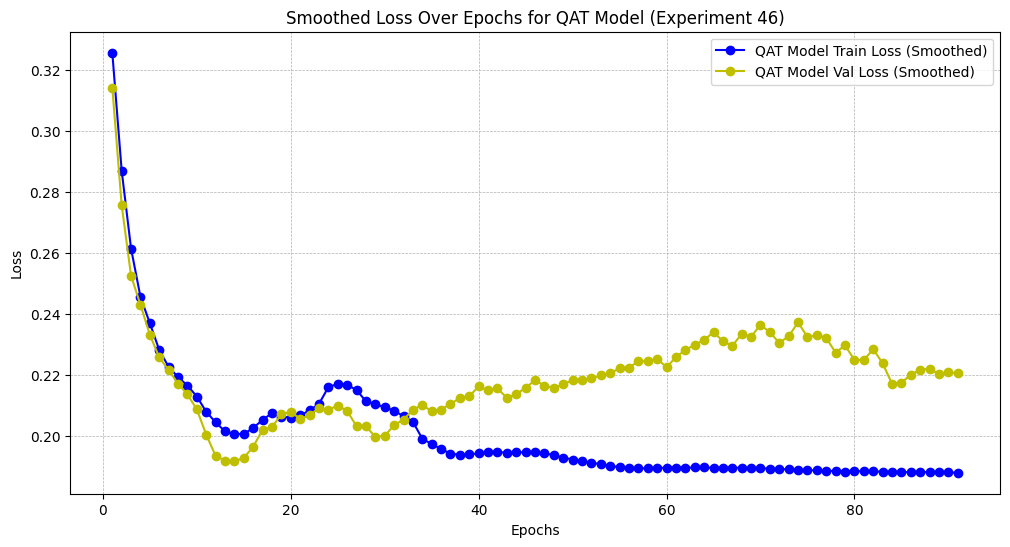

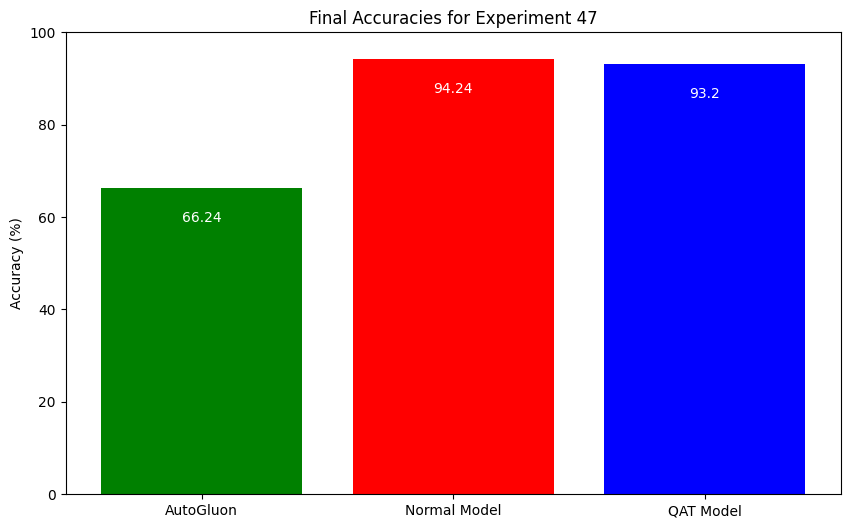

Experiment 47 Final Accuracies:
AutoGluon: 66.24%
Normal Model: 94.24%
QAT Model: 93.20%
Epochs: 30



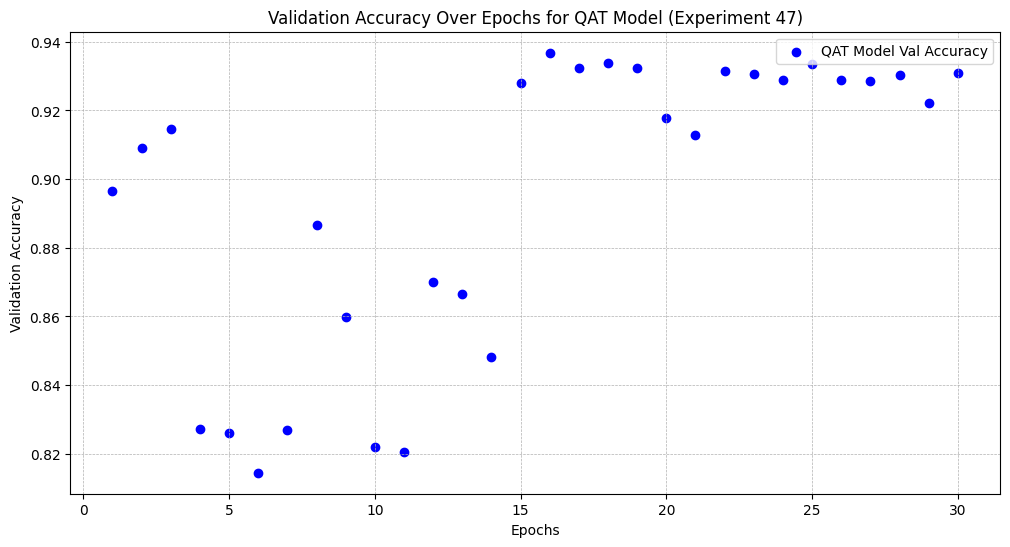

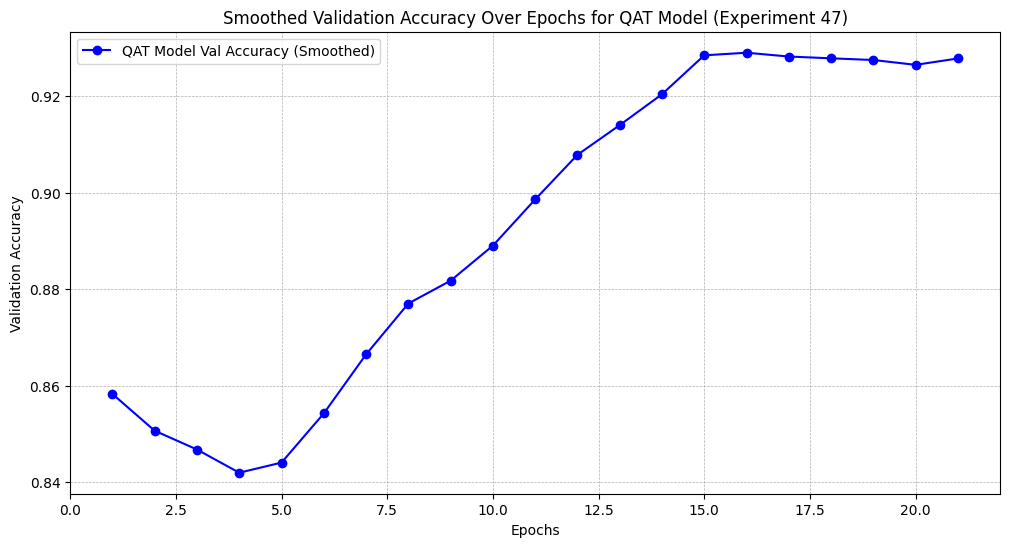

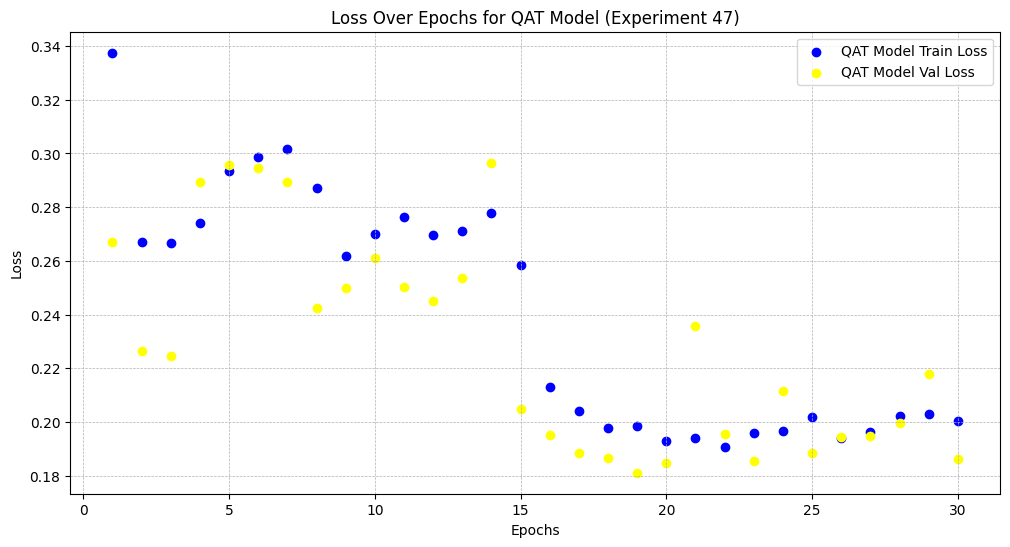

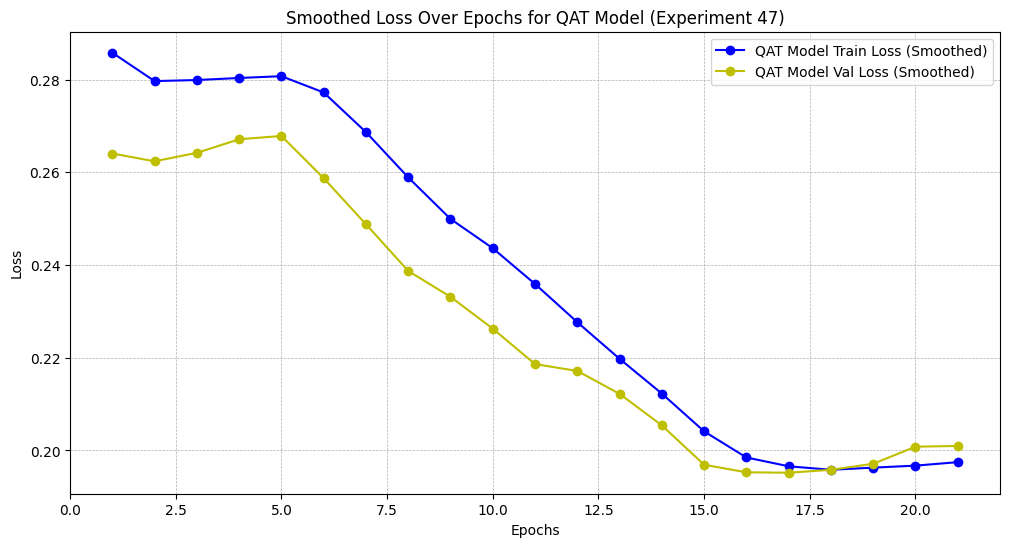

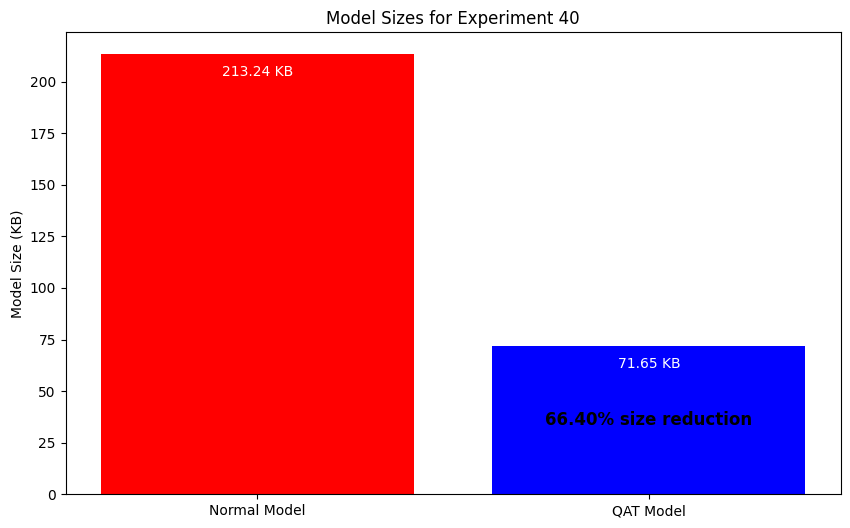

Experiment 40 Model Sizes:
Normal Model: 213.24 KB
QAT Model: 71.65 KB
Size reduction: 66.40%



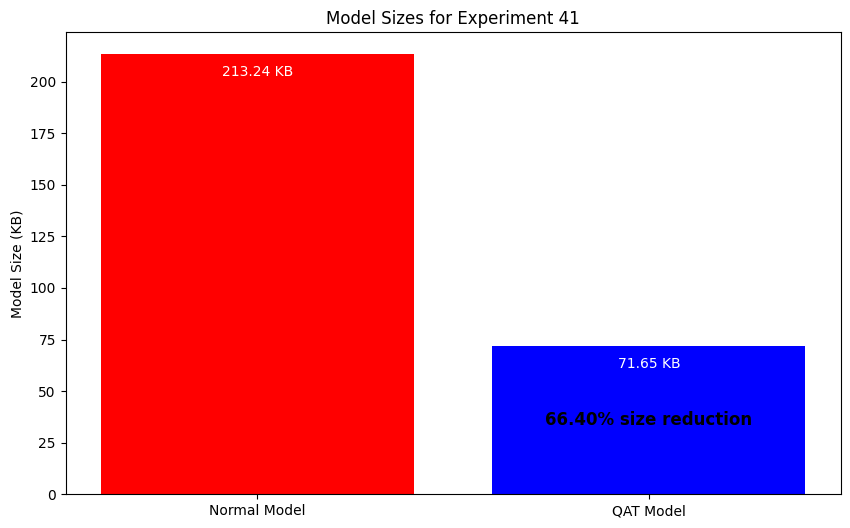

Experiment 41 Model Sizes:
Normal Model: 213.24 KB
QAT Model: 71.65 KB
Size reduction: 66.40%



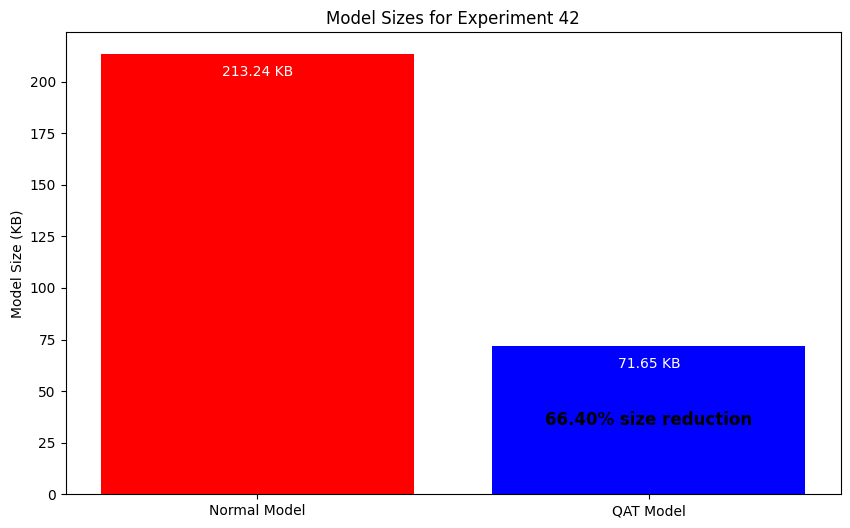

Experiment 42 Model Sizes:
Normal Model: 213.24 KB
QAT Model: 71.65 KB
Size reduction: 66.40%



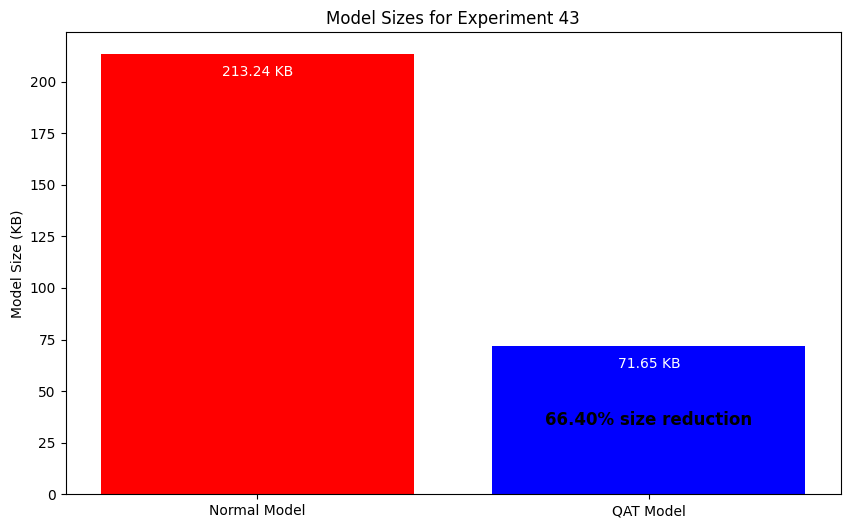

Experiment 43 Model Sizes:
Normal Model: 213.24 KB
QAT Model: 71.65 KB
Size reduction: 66.40%



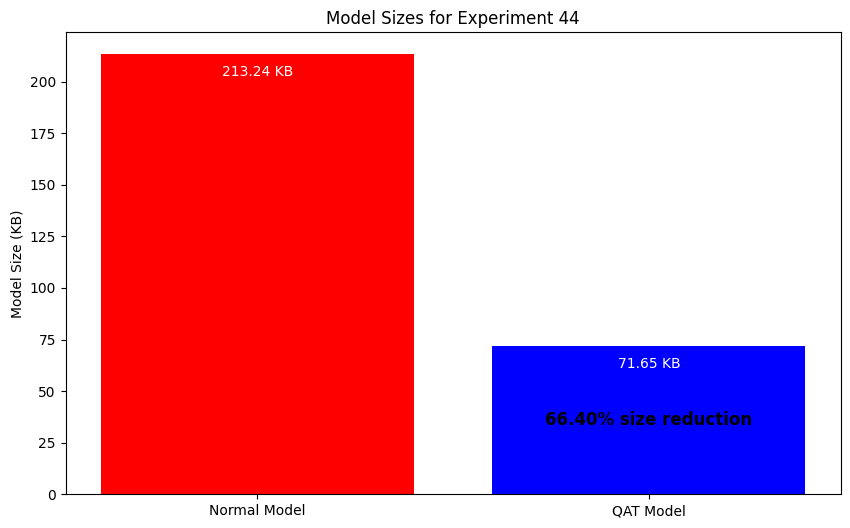

Experiment 44 Model Sizes:
Normal Model: 213.24 KB
QAT Model: 71.65 KB
Size reduction: 66.40%



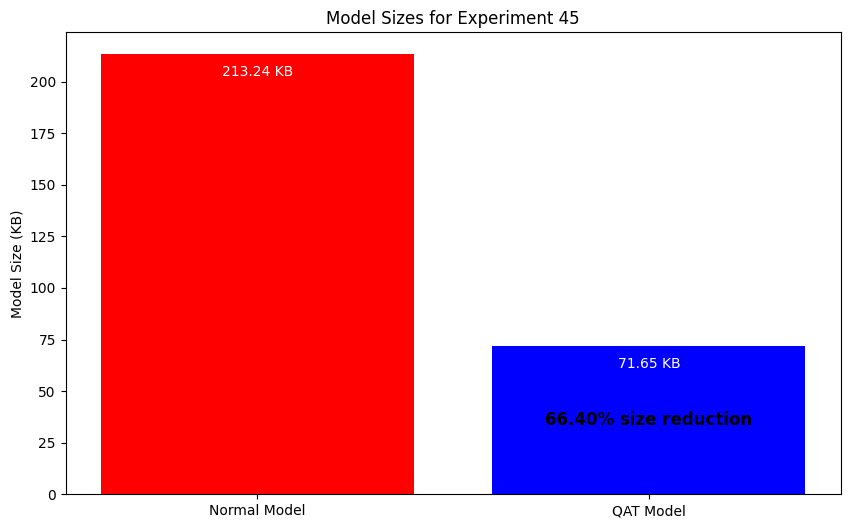

Experiment 45 Model Sizes:
Normal Model: 213.24 KB
QAT Model: 71.65 KB
Size reduction: 66.40%



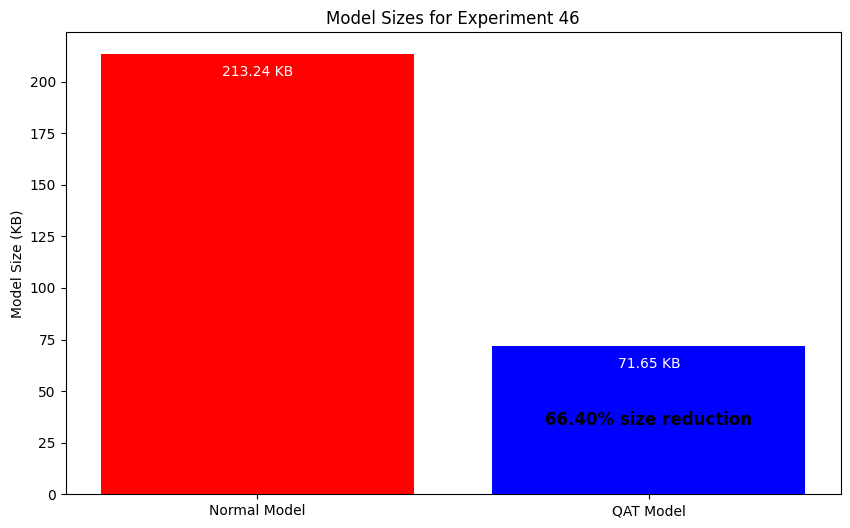

Experiment 46 Model Sizes:
Normal Model: 213.24 KB
QAT Model: 71.65 KB
Size reduction: 66.40%



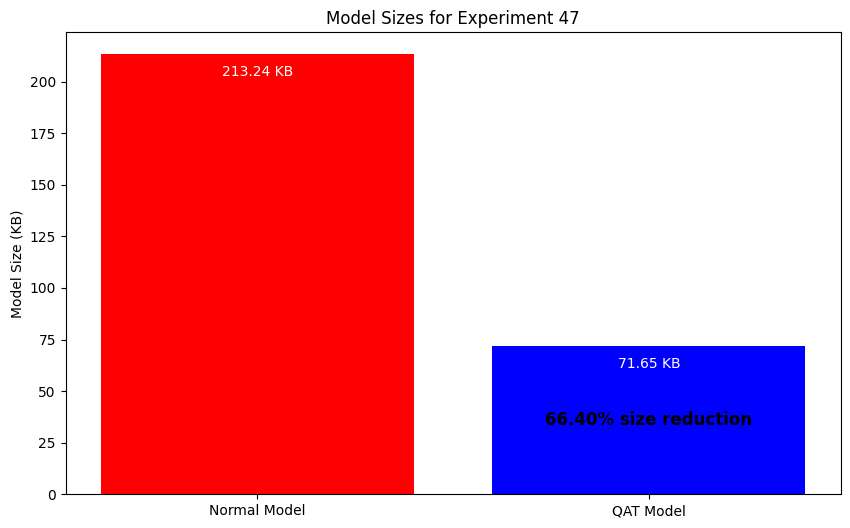

Experiment 47 Model Sizes:
Normal Model: 213.24 KB
QAT Model: 71.65 KB
Size reduction: 66.40%



In [13]:
# Directory containing the log files
log_directory = './datasets/CICIDS2017/balanced_binary/compressed_models'

# Parse all logs and plot data
experiment_data, filenames = parse_all_logs(log_directory)
plot_data(experiment_data, filenames)